<a href="https://colab.research.google.com/github/anamanuellar/Strategic_Financial_Performance_Analysis/blob/main/Financial_Performance_Analysis_of_Companies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Strategic Financial Performance Analysis**



**Author:** Ana Manuella Ribeiro

**Domain:** Corporate Finance & Data Analytics

## 1. Executive Summary


This project aims to diagnose the financial health of a multinational corporation by analyzing Sales, Costs, and Profitability data. The goal is to move beyond descriptive metrics to prescriptive insights, addressing:

1.  **Operational Efficiency:** Is revenue growth translating into real profit?
2.  **Seasonality:** Are there temporal patterns requiring inventory or pricing adjustments?
3.  **Risk Assessment:** How do outliers (large contracts) impact business stability?

**Tech Stack:** Python (Pandas for ETL, Plotly/Seaborn for Visualization).

## 2. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [2]:
# Configuration for clean float display
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings
warnings.filterwarnings('ignore')


In [21]:
# Load Data
try:
    df = pd.read_csv('Financials.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: File not found. Please check the path.")

Dataset loaded successfully!


## 3. ETL Pipeline

In [22]:
# Initial Inspection
df.head(5)

,Segment,Country,Product,Discount Band,Units Sold,Manufacturing Price,Sale Price,Gross Sales,Discounts,Sales,COGS,Profit,Date,Month Number,Month Name,Year
0,Government,Canada,Carretera,None,"$1,618.50",$3.00,$20.00,"$32,370.00",$-,"$32,370.00","$16,185.00","$16,185.00",01/01/2014,1,January,2014
1,Government,Germany,Carretera,None,"$1,321.00",$3.00,$20.00,"$26,420.00",$-,"$26,420.00","$13,210.00","$13,210.00",01/01/2014,1,January,2014
2,Midmarket,France,Carretera,None,"$2,178.00",$3.00,$15.00,"$32,670.00",$-,"$32,670.00","$21,780.00","$10,890.00",01/06/2014,6,June,2014
3,Midmarket,Germany,Carretera,None,$888.00,$3.00,$15.00,"$13,320.00",$-,"$13,320.00","$8,880.00","$4,440.00",01/06/2014,6,June,2014
4,Midmarket,Mexico,Carretera,None,"$2,470.00",$3.00,$15.00,"$37,050.00",$-,"$37,050.00","$24,700.00","$12,350.00",01/06/2014,6,June,2014


In [23]:
# --- ETL & CLEANING FUNCTIONS ---

def clean_columns(df):
    """Strips whitespace from column names."""
    df.columns = df.columns.str.strip()
    return df

In [24]:
def clean_currency(value):
    """
    Converts currency strings (e.g., '$ 1,200.50') to float.
    Handles parentheses as negative values (Accounting format).
    """
    if isinstance(value, str):
        value = value.replace('$', '').replace(',', '').replace(' ', '')
        value = value.replace('-', '') # Handling hyphens as zero or formatting error
        if '(' in value and ')' in value:
            value = value.replace('(', '-').replace(')', '')
    try:
        return float(value)
    except ValueError:
        return 0.0

In [25]:
def process_financial_data(df):
    """
    Main pipeline to process the raw financial dataframe.
    """
    # 1. Clean Headers
    df = clean_columns(df)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].str.strip()

    # 2. Define money columns
    money_cols = ['Units Sold', 'Manufacturing Price', 'Sale Price',
                  'Gross Sales', 'Discounts', 'Sales', 'COGS', 'Profit']

    # 3. Apply cleaning to money columns
    for col in money_cols:
        df[col] = df[col].apply(clean_currency)

    # 4. Handle Dates
    df['Date'] = pd.to_datetime(df['Date'])

    # 5. Sort Months (Crucial for correct plotting)
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    df['Month Name'] = pd.Categorical(df['Month Name'], categories=month_order, ordered=True)

    # 6. Handle Nulls in Profit
    # Business Decision: Fill NaN Profit with (Sales - COGS)
    df['Profit'] = df['Profit'].fillna(df['Sales'] - df['COGS'])

    return df

In [26]:
# Execute Pipeline
df_clean = process_financial_data(df.copy())
print("Data Cleaning Complete. Data Types:")
print(df_clean.dtypes)

Data Cleaning Complete. Data Types:
Segment                        object
Country                        object
Product                        object
Discount Band                  object
Units Sold                    float64
Manufacturing Price           float64
Sale Price                    float64
Gross Sales                   float64
Discounts                     float64
Sales                         float64
COGS                          float64
Profit                        float64
Date                   datetime64[ns]
Month Number                    int64
Month Name                   category
Year                            int64
dtype: object


## 4. Profitability Analysis

In [27]:
# --- SEGMENT PROFITABILITY ANALYSIS ---

# Aggregating data
segment_analysis = df_clean.groupby('Segment')[['Sales', 'Profit']].sum().reset_index()
segment_analysis['Margin (%)'] = (segment_analysis['Profit'] / segment_analysis['Sales']) * 100

# Visualization with Plotly (Interactive)
fig = px.bar(segment_analysis, x='Segment', y='Sales',
             color='Margin (%)',
             title='Total Sales by Segment & Profit Margin (Color Scale)',
             labels={'Sales': 'Gross Revenue ($)', 'Segment': 'Market Segment'},
             text_auto='.2s',
             color_continuous_scale='RdYlGn') # Red for low margin, Green for high

fig.update_layout(title_x=0.5)
fig.show()

## 5. Seasonality

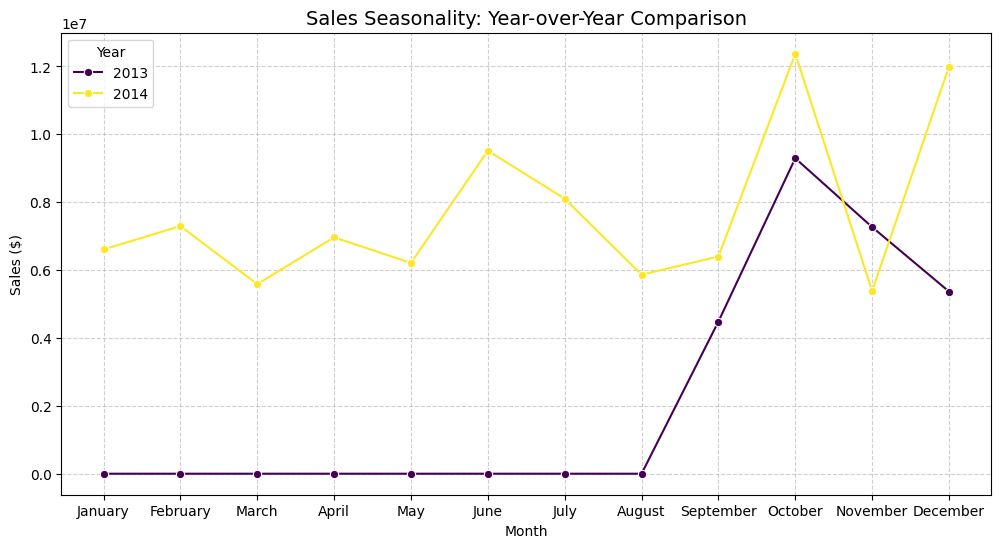

In [28]:
# --- SEASONALITY ANALYSIS (Year-to-Date) ---

# Grouping by Month
monthly_perf = df_clean.groupby(['Year', 'Month Name'])['Sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_perf, x='Month Name', y='Sales', hue='Year', marker='o', palette='viridis')
plt.title('Sales Seasonality: Year-over-Year Comparison', fontsize=14)
plt.ylabel('Sales ($)')
plt.xlabel('Month')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Year')
plt.show()

## 6. Risk & Outliers

Risk Detected: 53 high-value contracts identified as Outliers.
Revenue Impact: Outliers represent 35.0% of Total Sales.


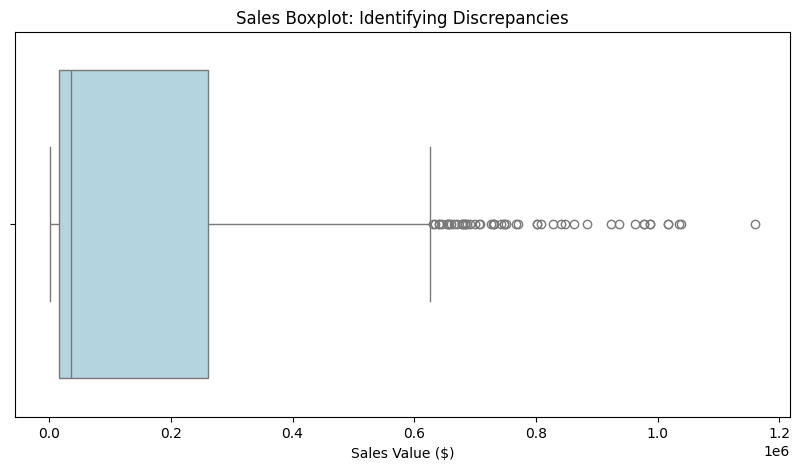

In [29]:
# --- RISK MANAGEMENT: OUTLIER ANALYSIS ---

# IQR Calculation
Q1 = df_clean['Sales'].quantile(0.25)
Q3 = df_clean['Sales'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

outliers = df_clean[df_clean['Sales'] > upper_bound]

print(f"Risk Detected: {len(outliers)} high-value contracts identified as Outliers.")
print(f"Revenue Impact: Outliers represent {outliers['Sales'].sum() / df_clean['Sales'].sum():.1%} of Total Sales.")

# Boxplot Visualization
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_clean['Sales'], color='lightblue')
plt.title('Sales Boxplot: Identifying Discrepancies', fontsize=12)
plt.xlabel('Sales Value ($)')
plt.show()

## 7. Strategic Conclusions & Recommendations

Based on the Exploratory Data Analysis (EDA), we identified critical decision points:

1.  **Focus on Channel Partners:** This segment yields the healthiest margins (~73%). I recommend reallocating the marketing budget to expand this channel.
2.  **Enterprise Risk:** Despite high volume, margins are dangerously low. A review of the discount policy (`Discounts` column) for large corporate contracts is necessary.
3.  **Dependence on "Whales":** A significant portion of revenue relies on a few high-value outliers. This indicates concentration risk; the strategy should shift towards pulverizing revenue into smaller, recurring contracts to improve stability.
4.  **Seasonal Patterns:** October and December show sales peaks. Inventory planning and logistics should start in August to prevent stockouts.